# PALLADIO example

## Imports

In [14]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  # noqa

# Plotting
# import matplotlib
# matplotlib.use('Agg')

import palladio
import palladio.analysis
import palladio.plotting

from collections import namedtuple

# Dataset stuff
from palladio import datasets

# Classifiers
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Model selection
from sklearn.model_selection import GridSearchCV


mpi4py module not found. PALLADIO cannot run on multiple machines.
dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtins__', '__file__', '__cached__', 'np', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'matthews_corrcoef', 'division', 'check_array', 'check_consistent_length', 'column_or_1d', 'string_types', 'warnings', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'explained_variance_score', 'r2_score', 'rmetrics'])


/home/matteo/miniconda3/envs/pd3/lib/python3.6/site-packages/palladio-2.0.2-py3.6.egg/palladio/model_assessment.py:45: UserWarning: mpi4py module not found. PALLADIO cannot run on multiple machines.
/home/matteo/miniconda3/envs/pd3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


KeyError: 'mean_absolute_error'

## Configuration

### Datasets

In [3]:
# Dataset loading
# data_path = '/home/matteo/jdoe-shared/matteo/Thesis_experiments/Golub/data/gedm.csv'
# target_path = '/home/matteo/jdoe-shared/matteo/Thesis_experiments/Golub/data/labels.csv'

data_path = '/home/matteo/projects/palladio/palladio/config_templates/data/gedm.csv'
target_path = '/home/matteo/projects/palladio/palladio/config_templates/data/labels.csv'



data_loading_options = target_loading_options = {                                                                                                                                                                                  
    'delimiter': ',',                                                                                                                                                                                     
    'header': 0,                                                                                                                                                                                          
    'index_col': 0                                                                                                                                                                                        
}

dataset = datasets.load_csv(data_path, target_path,                                                                                                                                                       
                            data_loading_options=data_loading_options,                                                                                                                                    
                            target_loading_options=target_loading_options,                                                                                                                                
                            samples_on='col')                                                                                                                                                             
data, labels = dataset.data, dataset.target
feature_names = dataset.feature_names



### Session

In [4]:
# Subfolder where results will be saved
session_folder = '/tmp/results'

# The learning task, if None palladio tries to guess it
# [see sklearn.utils.multiclass.type_of_target]

learning_task = None

n_splits_permutation = 5
n_splits_regular = 5

### Learning algorithms

In [5]:
# STEP 1: Variable selection                                                                                                                                                                              
vs = RFE(LinearSVC(loss='hinge'), step=0.3)                                                                                                                                                               

# STEP 2: Classification                                                                                                                                                                                  
clf = LinearSVC(loss='hinge')                                                                                                                                                                             

# COMPOSE THE PIPELINE
pipe = Pipeline([
    ('variable_selection', vs),
    ('classification', clf),
])

# Set the estimator to be a GridSearchCV
param_grid = {
    'variable_selection__n_features_to_select': [10, 20, 50],
    'variable_selection__estimator__C': np.logspace(-4, 0, 5),
    'classification__C': np.logspace(-4, 0, 5),
}

estimator = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='accuracy')

# Set options for ModelAssessment
ma_options = {
    'test_size': 0.25,
    'scoring': 'accuracy',
    'n_jobs': -1,
    'n_splits': n_splits_regular
}

### Analysis configuration

In [6]:
vs_analysis = 'variable_selection'

frequency_threshold = 0.75

# Plotting Options
score_surfaces_options = {
    'logspace': ['variable_selection__C'],
    'plot_errors': True
}

### Composing configuration object

In [6]:
# TODO must fix
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
config_dict = {
    # Dataset
    'data' : data,
    'labels' : labels,
    'feature_names' : feature_names,
    # Session
    'session_folder' : session_folder,
    'learning_task' : learning_task,
    'n_splits_permutation' : n_splits_permutation,
    # Learning algorithm
    'estimator' : estimator,
    'param_grid' : param_grid,
    'ma_options' : ma_options,
    # Analysis
    'vs_analysis' : vs_analysis,
    'frequency_threshold' : frequency_threshold,
    'score_surfaces_options' : score_surfaces_options,
    
    
}

config = Struct(**config_dict)

## Experiment running

In [7]:
# regular_batch, permutation_batch = palladio.job_distribution.main(config=config)

## Analysis

In [8]:
# performance_regular = palladio.analysis.performance_metrics(
#     regular_batch.cv_results_, 
#     config.labels, 
#     target='classification'
# )

# performance_permutation = palladio.analysis.performance_metrics(
#     permutation_batch.cv_results_, 
#     config.labels, 
#     target='classification'
# )

# metric = 'accuracy_score'

# palladio.plotting.distributions(
#             v_regular=performance_regular[metric],
# #             v_permutation=performance_permutation.get(metric, []),
#             v_permutation=performance_permutation[metric],
#             metric=metric
# )


In [3]:
performance_regular = {'accuracy_score': [0.90000000000000002,
  0.90000000000000002,
  1.0,
  1.0,
  0.90000000000000002],
 'balanced_accuracy': [0.83333333333333326,
  0.83333333333333326,
  1.0,
  1.0,
  0.83333333333333326],
 'f1_score': [0.93333333333333335,
  0.93333333333333335,
  1.0,
  1.0,
  0.93333333333333335],
 'matthews_corrcoef': [0.76376261582597316,
  0.76376261582597305,
  1.0,
  1.0,
  0.76376261582597316],
 'precision_score': [0.875, 0.875, 1.0, 1.0, 0.875],
 'recall_score': [1.0, 1.0, 1.0, 1.0, 1.0]}

performance_permutation = {'accuracy_score': [0.59999999999999998,
  0.40000000000000002,
  0.59999999999999998,
  0.80000000000000004,
  0.29999999999999999],
 'balanced_accuracy': [0.42857142857142855,
  0.38095238095238093,
  0.42857142857142855,
  0.66666666666666663,
  0.30952380952380953],
 'f1_score': [0.75, 0.5, 0.75, 0.87500000000000011, 0.36363636363636365],
 'matthews_corrcoef': [-0.21821789023599242,
  -0.21821789023599242,
  -0.21821789023599233,
  0.50917507721731559,
  -0.35634832254989923],
 'precision_score': [0.66666666666666663,
  0.59999999999999998,
  0.66666666666666663,
  0.77777777777777779,
  0.5],
 'recall_score': [0.8571428571428571,
  0.42857142857142855,
  0.8571428571428571,
  1.0,
  0.2857142857142857]}

[balanced_accuracy] Two sample Kolmogorov-Smirnov test: Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)
[accuracy_score] Two sample Kolmogorov-Smirnov test: Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


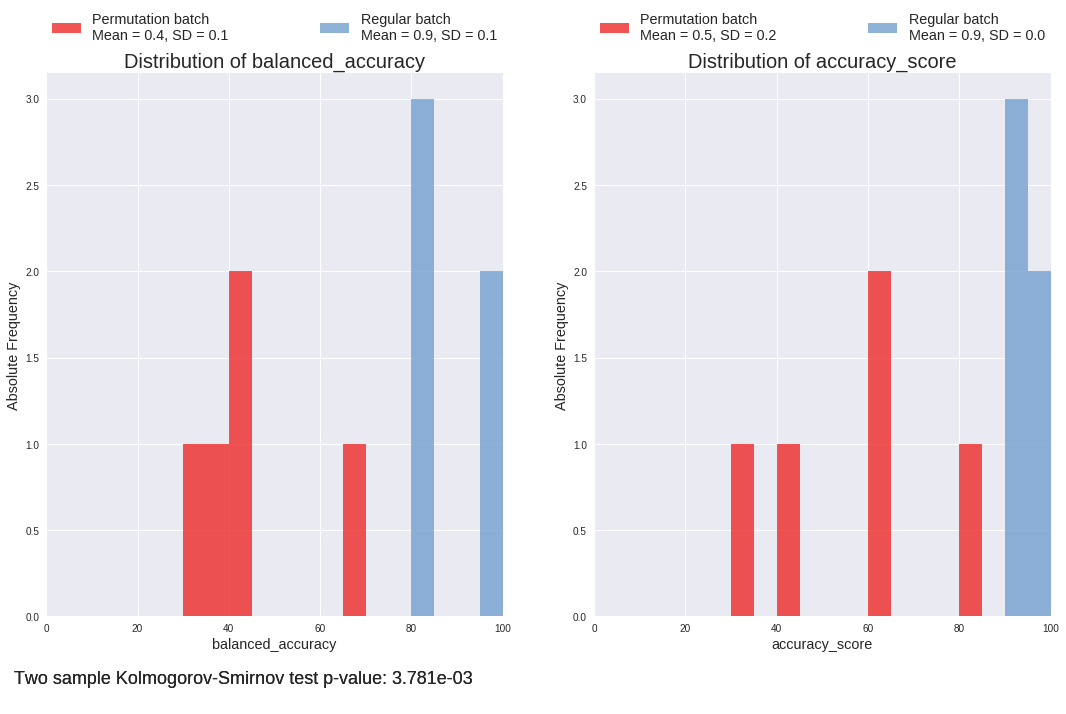

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

metric = 'balanced_accuracy'

palladio.plotting.distributions(
            v_regular=performance_regular[metric],
            v_permutation=performance_permutation[metric],
            fig=fig, ax=ax1,
            metric=metric
)


metric = 'accuracy_score'

palladio.plotting.distributions(
            v_regular=performance_regular[metric],
            v_permutation=performance_permutation[metric],
            fig=fig, ax=ax2,
            metric=metric
)

[balanced_accuracy] Two sample Kolmogorov-Smirnov test: Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)
[accuracy_score] Two sample Kolmogorov-Smirnov test: Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


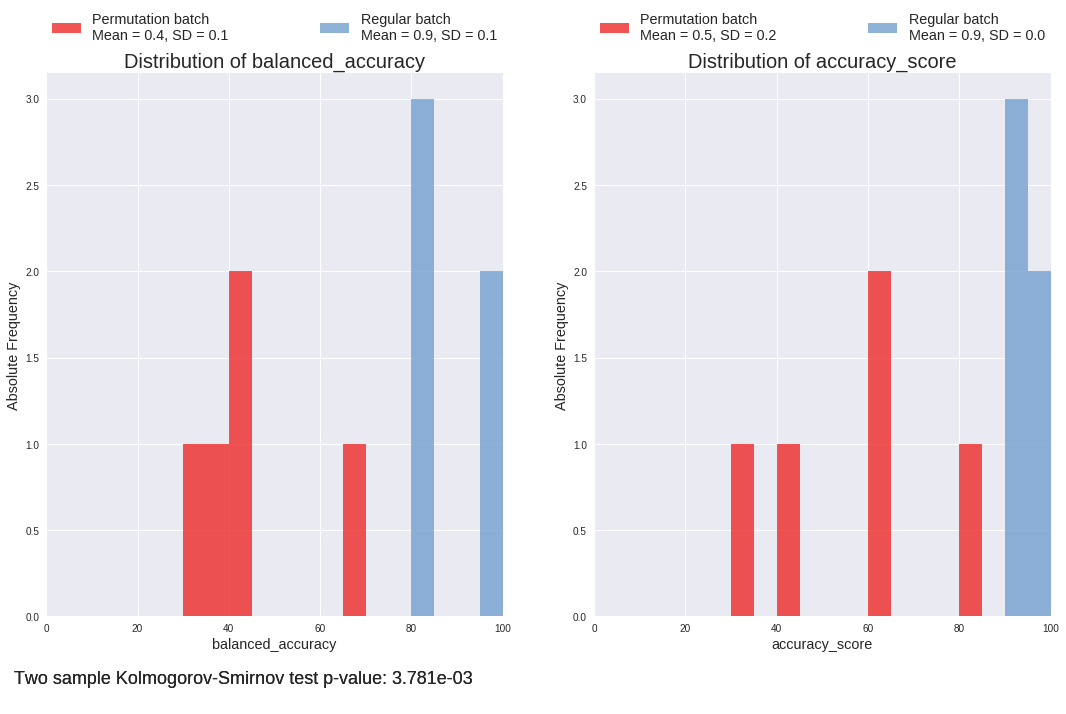

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

metric = 'balanced_accuracy'

palladio.plotting.distributions(
            v_regular=performance_regular[metric],
            v_permutation=performance_permutation[metric],
            fig=fig, ax=ax1,
            metric=metric
)


metric = 'accuracy_score'

palladio.plotting.distributions(
            v_regular=performance_regular[metric],
            v_permutation=performance_permutation[metric],
            fig=fig, ax=ax2,
            metric=metric
)